# ApRES data quality control 
Use this notebook to quality control data collected during the deployment of ApRES units. 

As described in the [checklist](https://docs.google.com/document/d/1szAn3jsHMNxfMRui8-35VI7EjeVs8Lp5sB5TTNECf4c/edit), a short series of unattended measurements should be made using attenuator and gain settings selected by performing trial bursts. This notebook can then be used to load and examine those data. This will inform any changes needed to the survey (e.g., changing gain or attenuator settings, or the number of sub-bursts), or confirm that the selected settings are, to our best estimate, the most appropriate to be used.  

A pdf of this notebook with the outputs produced using an example `.dat` file form Thwaites Glacier is saved as ApRES_deployment_QC_v1.pdf. 

If needed, a conda environment can be created using the provided environment.yml file. Type the following in the terminal:

```
conda env create -f environment.yml
```

You can then activate the environment either by typing this in the terminal:

```
conda activate apres_testing_env
```

or by selecting the environment in vscode (top right).

## Load the XApRES package

In [3]:
import xapres as xa
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np


## Point the code to the data
Change the path in the cell below to be the path to the folder containing the `.dat` files collected during the short unattended survey. 

In [ ]:
# ../../data/TG is the relative path to a folder containing an example .dat file collected on Thwaites Glacier in 2023
directory = "../../data/TG"

## Load the data

In [18]:
unattended_data = xa.load.generate_xarray(directory=directory)
unattended_data

<xarray.Dataset> Size: 98MB
Dimensions:          (time: 2, chirp_time: 40001, chirp_num: 100,
                      attenuator_setting_pair: 1, profile_range: 10462)
Coordinates:
  * time             (time) datetime64[ns] 16B 2023-02-12T04:37:04 2023-02-13...
  * chirp_time       (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0
  * profile_range    (profile_range) float64 84kB 0.0 0.2103 ... 2.2e+03 2.2e+03
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
    filename         (time) <U37 296B '../../data/TG/DATA2023-02-12-0437.DAT'...
    burst_number     (time) int64 16B 0 1
    AFGain           (attenuator_setting_pair) int64 8B -4
    attenuator       (attenuator_setting_pair) float64 8B 22.0
    orientation      (time) <U7 56B 'unknown' 'unknown'
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 64MB ...
    profile          (time, profile_range, chirp_num, attenuator_setting_pair) complex128 33MB ...
    latitude         (time) float64 16B 0.0 0.0
    longitude        (time) float64 16B 0.0 0.0
    battery_voltage  (time) float64 16B 12.39 12.39
    temperature_1    (time) float64 16B 493.5 493.6
    temperature_2    (time) float64 16B 498.3 498.1

# Simple checks

### Check that time of the first and last measurements match your notes from the field

In [19]:
print(f" time of first measurement: {unattended_data.time.isel(time=0).values}")
print(f" time of last measurement: {unattended_data.time.isel(time=-1).values}")

 time of first measurement: 2023-02-12T04:37:04.000000000
 time of last measurement: 2023-02-13T04:37:10.000000000


### Check the interval between measurements
This should be equal to the value of RepSecs (assuming IntervalMode=0). Note that the example `.dat` file only contains two measurements, so we only get one value back from the cell below. In your case you will likely have more than two measurements, so you will get more values back from the cell below. 

In [22]:
print((unattended_data.time.values[1:] - unattended_data.time.values[:-1])/1e9) # the /1e9 is because the time is in nanoseconds

[86406]


### Check the battery voltage didnt change dramatically

In [23]:
print(unattended_data.battery_voltage.values)
# unattended_data.battery_voltage.plot()  # or you can plot it by uncommenting this line

[12.3871 12.3871]


## Check the actual data
### plot a single chirp

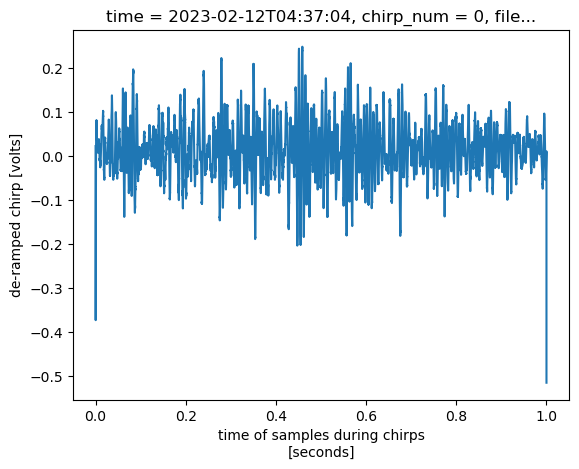

In [24]:
unattended_data.isel(time=0, attenuator_setting_pair =0, chirp_num = 0).chirp.plot()  # plot the first chirp

### Look for clipping
...by plotting all the chirp samples for all the bursts for a given attenuator setting pair

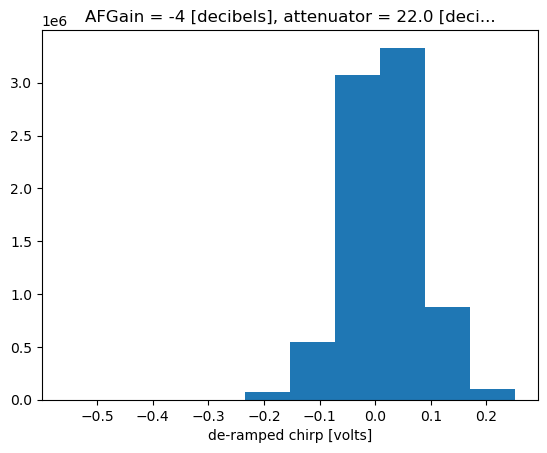

In [25]:
for a in unattended_data.attenuator_setting_pair.values:
    unattended_data.chirp.isel(attenuator_setting_pair = a).plot()  # plot all chirps
    plt.show()

### Plot a profile 
To see if your data has a reasonable noise floor and you can see the bed.

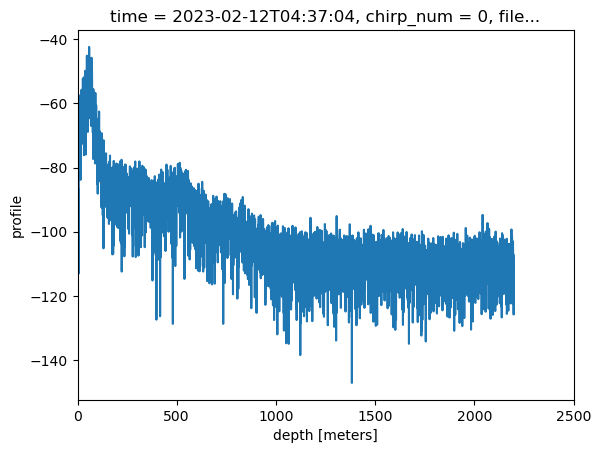

In [28]:
unattended_data.isel(time=0, attenuator_setting_pair =0, chirp_num = 0).profile.dB().plot(xlim = (0, 2500))  

Note that in the example data here we can see the bed without stacking (i.e. averaging) all the chirps in each burst. 

You can stack the data as follows:


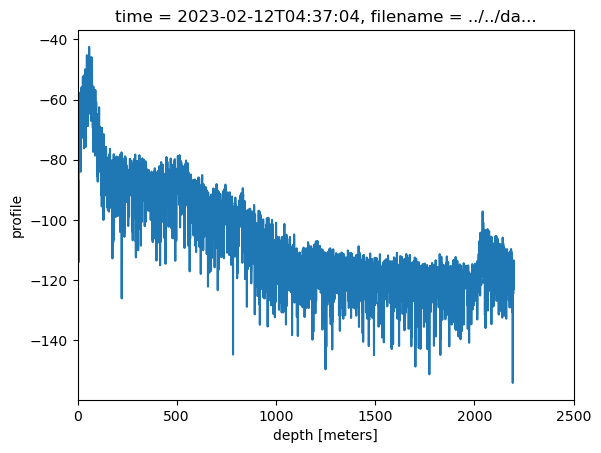

In [29]:
unattended_data.isel(time=0, attenuator_setting_pair =0).profile.mean(dim='chirp_num').dB().plot(xlim = (0, 2500))  

The bed is visible in the above plot at around 2200m depth. 
We dont know if you will be able to see the bed in the unstacked data (i.e. just a single chirp) or after stacking, but it will likely look something like this if you can. 

## Additional ideas for plotting
Below are some additional ideas for plotting the data and looking at the effect of stacking to perhaps estimate whether we need more chirps per measurement. 

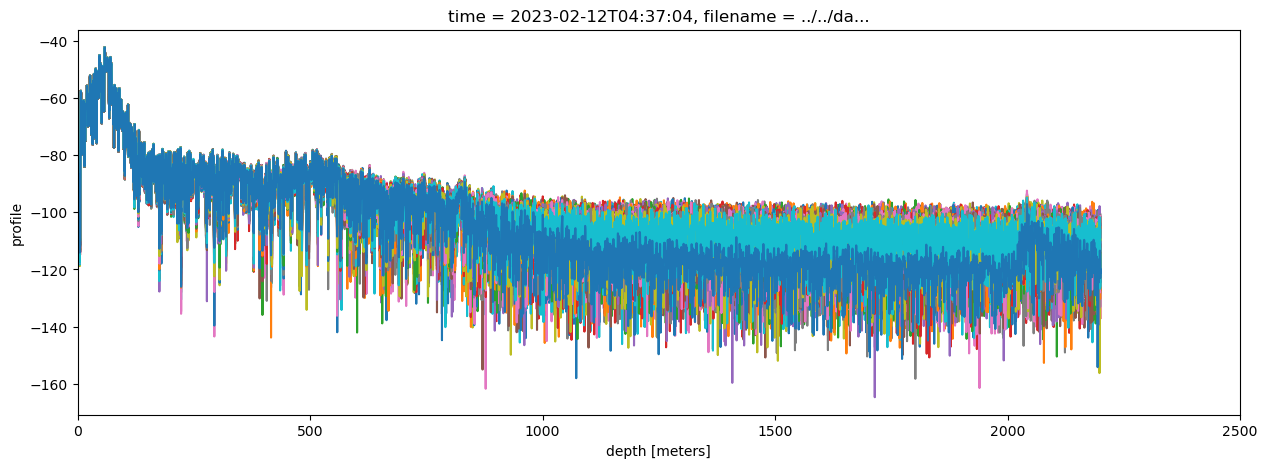

In [33]:
unattended_data.isel(time=0, attenuator_setting_pair =0).profile.dB().plot(x='profile_range', xlim = (0, 2500), hue = 'chirp_num', figsize = (15, 5), add_legend = False);
unattended_data.isel(time=0, attenuator_setting_pair = 0).profile.mean(dim='chirp_num').dB().plot(add_legend = False)
plt.savefig('TG_unstacked_and_stacked.png')

If you cannot see this plot because it has not been saved with the notebook it is saved as TG_unstacked_and_stacked.png

### Create an xarray with many stacked profiles, each one using a different number of profiles in the stacking

In [36]:
da_list=[]
for n in unattended_data.chirp_num.values:
    da_list.append(unattended_data.isel(time=0, attenuator_setting_pair=0, chirp_num = slice(0,n)).profile.mean(dim='chirp_num').dB())

In [38]:
average_over_n_chirps = xr.DataArray(np.arange(0, len(unattended_data.chirp_num)), dims='average_over_n_chirps', name='average_over_n_chirps')
da = xr.concat(da_list, dim = average_over_n_chirps).rename('profile')

Take a look at the effect of stacking on the noise floor by plotting out three profiles from the xarray we created above. The first profile is just one single profile, the second is created from 9 profiles and the third is created from 19 profiles.

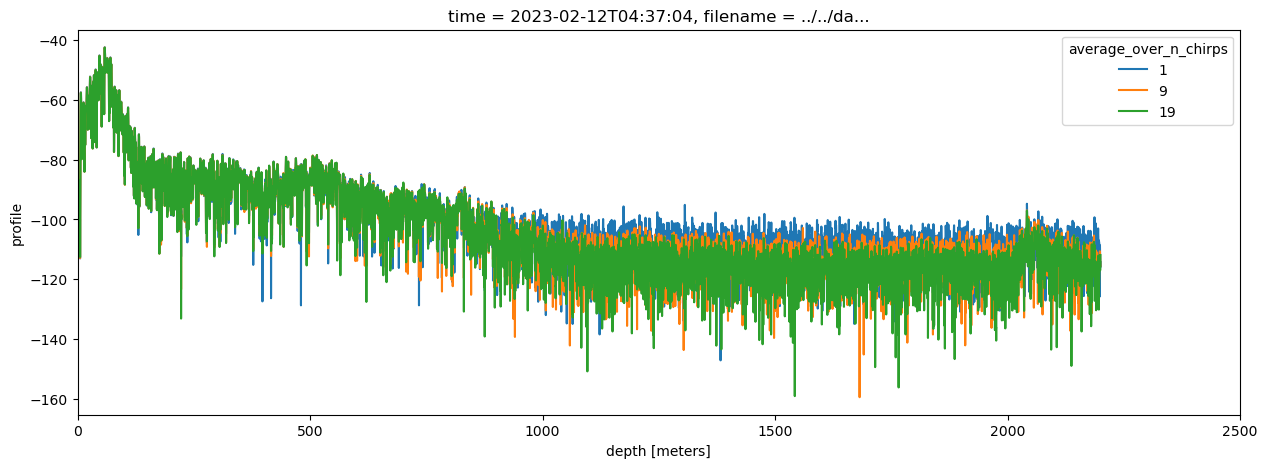

In [41]:
da.isel(average_over_n_chirps =[1, 9, 19]).plot(xlim = (0, 2500), hue = 'average_over_n_chirps', figsize = (15, 5));
plt.savefig('TG_average_over_n_chirps.png')

This plot is saved as TG_average_over_n_chirps.png